In [ ]:
#| include: false
! [ -e /content ] && pip install -Uqq gingado nbdev # install or upgrade gingado on colab

This notebook illustrates the use of `MachineControl`, the `gingado` estimator that calculates a synthetic control model with machine learning techniques.

## Setting

Use of the `MachineControl` estimator is illustrated with an admittedly simplistic estimation of the impact of softening labour regulation on output per worker, measured in constant 2017 international US dollars PPP.

More specifically, the example below focuses on Brazil's 2017 labour reforms (Law No 13,467/2017). The reform markedly deregulated labour markets, with the purpose of increasing productivity and thereby unlocking growth. Some of its main points are:

- prominence of collective bargaining between firms and employees over statutory "blanket" provisions

- lower costs for employers of employment termination without just cause

- discouraging of labour litigation by employees, previously diagnosed as being excessive and contributing to clogging the judicial system 

The reform was enacted in July 2017 and went into effect in November of the same year.

## Using machine learning

`MachineControl` does the following:

1. automatically select a group of countries from a global list to form a smaller set of control countries

2. estimate a GDP value for "synthetic Brazil" using pre-enactment data on the outcome of interest

3. check the statistical quality of the synthetic control

4. calculates the difference between post-reforms actual Brazilian GDP growth to synthetic Brazil's to measure the effect of the labour reform.

> Note: There are many other variables that would be interesting for this study as well, such as various labour market indicators.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from gingado.utils import list_all_dataflows, load_SDMX_data
from gingado.estimators import MachineControl
from sklearn.cluster import AffinityPropagation
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE

## Downloading the data

First, we list all dataflows obtainable with SDMX.

In [ ]:
dflows = list_all_dataflows(return_pandas=True)

2023-09-14 22:42:31,803 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-14 22:42:51,049 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-14 22:42:51,959 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-14 22:42:55,113 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>
2023-09-14 22:42:56,250 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>


In [ ]:
dflows[dflows.str.contains('per worker', case=False)]

ILO  DF_GDP_205U_NOC_NB    Output per worker (GDP constant 2015 US $) -- ...
     DF_GDP_211P_NOC_NB    Output per worker (GDP constant 2017 internati...
     DF_SDG_A821_NOC_RT    SDG indicator 8.2.1 - Annual growth rate of ou...
     DF_SDG_B821_NOC_RT    SDG indicator 8.2.1 - Annual growth rate of ou...
Name: dataflow, dtype: object

Let's get the data on output per worker provided by the International Labour Organisation (ILO):

In [ ]:
outcome_var = load_SDMX_data(
    sources={'ILO': 'DF_GDP_211P_NOC_NB'}, 
    keys={'FREQ': 'A'}, 
    params={'startPeriod': 2000, 'endPeriod': 2022}
)

2023-09-14 22:42:58,334 pandasdmx.reader.sdmxml - DEBUG: Truncate sub-microsecond time in <Prepared>


Querying data from ILO's dataflow 'DF_GDP_211P_NOC_NB' - Output per worker (GDP constant 2017 international $ at PPP) -- ILO modelled estimates, Nov. 2022...


2023-09-14 22:42:59,461 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


This dataflow provides one series for each country, as seen below.

In [ ]:
col_fields = pd.DataFrame([c.split("__") for c in outcome_var.columns])
for col in col_fields.columns:
    print("No of unique values for column No", col, ": ", col_fields[col].nunique())
print("\nFirst five rows:")
print(col_fields.head())

No of unique values for column No 0 :  1
No of unique values for column No 1 :  271
No of unique values for column No 2 :  1
No of unique values for column No 3 :  1

First five rows:
     0                       1  2            3
0  ILO  DF_GDP_211P_NOC_NB_AFG  A  GDP_211P_NB
1  ILO  DF_GDP_211P_NOC_NB_AGO  A  GDP_211P_NB
2  ILO  DF_GDP_211P_NOC_NB_ALB  A  GDP_211P_NB
3  ILO  DF_GDP_211P_NOC_NB_ARE  A  GDP_211P_NB
4  ILO  DF_GDP_211P_NOC_NB_ARG  A  GDP_211P_NB


Because 271 is much higher than the number of countries that usually report international statistics (close to 200), it is likely some 70 columns or more correspond to aggregations, typically used in statistics for convenience (eg, one code that encompasses all countries in the European Union, etc). We need to take them out, in case Brazil is a constituent of any of those aggregations.

One common way of spotting these aggregations in international statistics is  finding the country codes that begin with "X".

In [ ]:
len([c for c in outcome_var.columns if "DF_GDP_211P_NOC_NB_X" in c])

82

Also, we will take out other countries that have undergone labour reforms more or less around the same time. From @serra2022reforma, I am aware of Argentina 🇦🇷, Costa Rica 🇨🇷, Paraguay 🇵🇾, and Uruguay 🇺🇾. 

It is important to note, though, that these countries above were named by @serra2022reforma because their synthetic control donor pool consistent of geographically close countries. Other countries might have also enacted labour reforms in that period. For expositional purposes, we can assume no further country needs to be taken out of the same.

In [ ]:
col_filter = [
    c for c in outcome_var.columns
    if "DF_GDP_211P_NOC_NB_X" not in c
    and "DF_GDP_211P_NOC_NB_ARG" not in c
    and "DF_GDP_211P_NOC_NB_CRI" not in c
    and "DF_GDP_211P_NOC_NB_PAR" not in c
    and "DF_GDP_211P_NOC_NB_URY" not in c
]

X = outcome_var[col_filter]
X = X.dropna(axis=1)

# cleaning out the name to remove the constant portions across all countries
X.columns = [c.replace("ILO__DF_GDP_211P_NOC_NB_", "") \
    .replace("__A__GDP_211P_NB", "") for c in X.columns]

col_BRA = [c for c in X.columns if c == "BRA"]
y = X.pop(col_BRA[0])

assert X.shape[0] == y.shape[0]

This is what the series of annual output per worker in Brazil looks like. A vertical line marking November 2017, when the labour reforms entered into force.

Text(0.5, 1.0, 'Labour productivity in Brazil')

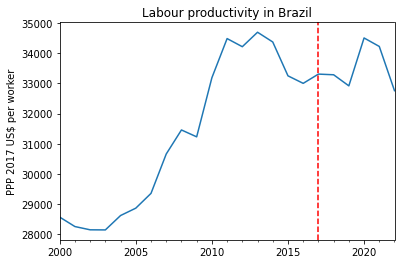

In [ ]:
law_date = '2017-11-11'
ylabel = 'PPP 2017 US$ per worker'

ax = y.plot(legend=False)
ax.axvline(x=law_date, color='r', linestyle='--')
plt.ylabel(ylabel)
plt.xlabel('')
plt.title('Labour productivity in Brazil')

Before creating the `MachineControl` object, a final comment on the intervention date.

Since the reforms were enacted and entered into force in the same year of 2017, we can be conservative and consider:
- pre-intervention data up to end-2016
- post-intervention data from 2018 onwards

In [ ]:
X_pre, y_pre = X[:'2016-12-31'], y[:'2016-12-31']

assert X_pre.shape[0] == y_pre.shape[0]
X_pre.shape, y_pre.shape

((17, 181), (17,))

## Using the `MachineControl` object

The code chunk below shows how a `MachineControl` object can be created.

As illustrated below, users can not only choose the clustering, estimator and manifold learning algorithms that best suit their needs, but also pass specific arguments to each of these elements.

In [ ]:
synth_BR = MachineControl(
    cluster_alg=AffinityPropagation(max_iter=10_000),
    estimator=RandomForestRegressor(),
    manifold=TSNE(perplexity=5)
)

Let's train and then inspect the `MachineControl` object:

In [ ]:
synth_BR.fit(X_pre, y_pre)

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


MachineControl(cluster_alg=AffinityPropagation(max_iter=10000),
               estimator=RandomForestRegressor(), manifold=TSNE(perplexity=5))

As shown above, the machine control estimator comprises:

1. A clustering algorithm that selects the donor pool from the larger population (affinity propagation)

2. A supervised learning algorithm that will use the donor pool to estimate contemporanous values for Brazil (random forest)

3. A manifold learning algorithm that summarises the different time series in a 2-dimensional embedding space, enabling easier comparison of Brazil with each other country and with the synthetic control (t-SNE)

At this stage, we can extract the list of donor countries, ie, those that will be used in the control.

In [ ]:
" ".join(synth_BR.donor_pool_)

'ALB BGR BIH BLR BRB BWA COL CUB DOM DZA EGY FJI GUY IRQ KAZ LCA MKD MUS NAM PSE SRB SWZ TUN VCT YEM ZAF'

These countries are: Albania 🇦🇱, Bulgaria 🇧🇬, Bosnia and Herzegovina 🇧🇦, Belarus 🇧🇾, Barbados 🇧🇧, Botswana 🇧🇼, Colombia 🇨🇴, Cuba 🇨🇺, Dominican Republic 🇩🇴, Algeria 🇩🇿, Egypt 🇪🇬, Fiji 🇫🇯, Guyana 🇬🇾, Iraq 🇮🇶, Kazakhstan 🇰🇿, Saint Lucia 🇱🇨, North Macedonia 🇲🇰, Mauritius 🇲🇺, Namibia 🇳🇦, State of Palestine 🇵🇸, Serbia 🇷🇸, Eswatini 🇸🇿, Tunisia 🇹🇳, Saint Vincent and the Grenadines 🇻🇨, Yemen 🇾🇪 and South Africa 🇿🇦.

> Note: This list does not imply all countries contribute equally to estimating the synthetic version of Brazil. In fact, some might even end up not even contributing in the estimating equation. The selected list also does not imply a causal explanation from any of those countries into the Brazilian dynamics. They are merely closest to Brazil in this clustering exercise, and as such, likely to be a good predictor at the same time period.

And here is how the outcome variable for these countries (grey) compares with Brazil's (red).

<AxesSubplot:xlabel='TIME_PERIOD'>

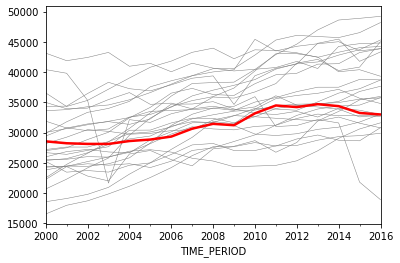

In [ ]:
ax = X_pre[synth_BR.donor_pool_].plot(legend=False, color="grey", linewidth=0.5)
y_pre.plot(ax=ax, color="red", linewidth=2.5)


Plotting the result of the manifold learning underscores whether the synthetic control seems indeed to come from a similar space in the data distribution as the entity of interest.

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


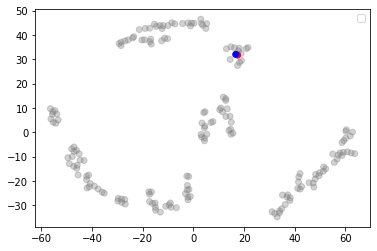

In [ ]:
colors = [(0.5, 0.5, 0.5, 0.35)] * X.shape[1] + ['red', 'blue']

fig, ax = plt.subplots()
ax.scatter(
    synth_BR.manifold_embed_[:, 0], synth_BR.manifold_embed_[:, 1],
    color=colors,
    )
ax.legend()
plt.show()

In [ ]:
synth_BR.control_quality_test_ / 100

0.019426995735370444

As can be seen in the graph above, the actual Brazil 🇧🇷 (blue) and the machine controls (red) are almost juxtaposed.

To confirm objectively that the control is good, the Euclidean distance between the embeddings for the control and the actual outcome are one of the lowest, more specifically at the 2% percentile. 

Together, both point to a strong signal that the control managed to replicate the pre-intervention outcome.

So now it's time to look at the results in the years following the event.

## Results

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


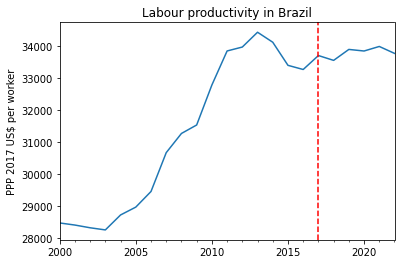

In [ ]:
ax = synth_BR.predict(X, y).plot(legend=False)
ax.axvline(x='2017-11-11', color='r', linestyle='--')
plt.ylabel('PPP 2017 US$ per worker')
plt.xlabel('')
plt.title("Labour productivity in Brazil")
plt.show()

### Treatment effect

The main result is shown below, corresponding to the difference between actual and estimated value for the whole time series (from 2000). If the red line (Brazil) stays close to the other ones - placebo estimations.

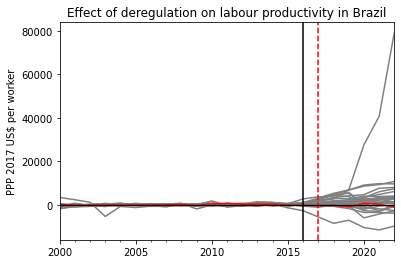

In [ ]:
all_diffs = pd.concat([
    synth_BR.placebo_diff_,
    synth_BR.diff_
], axis=1)
colors = ['grey'] * synth_BR.placebo_diff_.shape[1] + ['red']
y_label = 'PPP 2017 US$ per worker'
effect_title = "Effect of deregulation on labour productivity in Brazil"

ax = all_diffs.plot(legend=False, color=colors)
ax.axvline(x='2016-12-31', color='black', linestyle='solid')
ax.axvline(x='2017-11-11', color='red', linestyle='--')
ax.axhline(y=0, color='black', linewidth=1.2)
plt.ylabel(y_label)
plt.xlabel('')
plt.title(effect_title)
plt.show()

It seems there is some outlier effect with one of the control countries.

In [ ]:
synth_BR.placebo_diff_.loc['2022-01-01'].sort_values(ascending=False).index[0]

'GUY'

According to the code above, it is Guyana 🇬🇾. Now plotting without this country:

::: {.preview-image}

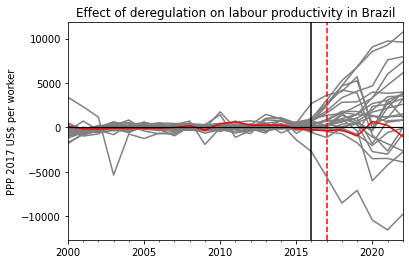

In [ ]:
colors = ['grey'] * (synth_BR.placebo_diff_.shape[1] - 1)+ ['red']
ax = all_diffs[[c for c in all_diffs.columns if c != "GUY"]].plot(legend=False, color=colors)
ax.axvline(x='2016-12-31', color='black', linestyle='solid')
ax.axvline(x='2017-11-11', color='red', linestyle='--')
ax.axhline(y=0, color='black', linewidth=1.2)
plt.ylabel(y_label)
plt.xlabel('')
plt.title(effect_title)
plt.show()

:::

## Interpretation

The above results hint at a null effect of the reforms on labour productivity after training cutoff date (black vertical line). If anything, the effect squarely close to zero throughout the years following the reform (red vertical line), even as the productivity for the majority of control countries actually went up in the years before the pandemic.

# References